# Home assignment (graded, individual, in 2 week)

### Peshkov Maksim

email to pandreyanov@gmail.com, use ipnb, use markdown, explain what you do

## Download packages

In [1]:
import scipy as sp
import scipy.linalg as spla
import scipy.optimize as spopt
import scipy.stats as spst

import numpy as np
import numpy.linalg as npla

import statsmodels as sm
import statsmodels.api as sma
smfOLS = sma.regression.linear_model.OLS.from_formula
smfLGT = sm.discrete.discrete_model.Logit.from_formula
from statsmodels.nonparametric.kernel_regression import KernelReg as KernelReg

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

from inspect import signature as sig

In [2]:
import statsmodels.formula.api as smf
from tqdm.notebook import tqdm

In [3]:
# matplotlib image size and resolution
mpl_options = {"figsize":(8,8), "dpi":100}
sns.set(rc={'figure.figsize':(12,8)})

## Data for assignment 1

In [4]:
def func1(x):
    if x < 1:
        return .2*x
    if x >= 1:
        return .7*x - .25

In [5]:
x = np.random.uniform(0,2, 1000)
y = np.array([func1(i) for i in x]) + np.random.uniform(0,.2,1000)

In [6]:
data = np.vstack((x,y))
df = pd.DataFrame(data.T, columns = ['x', 'y'])

xleft = df[df.x<1].x.values
xright = df[df.x>=1].x.values

yleft = df[df.x<1].y.values
yright = df[df.x>=1].y.values

OLS regression with discontinuity correction

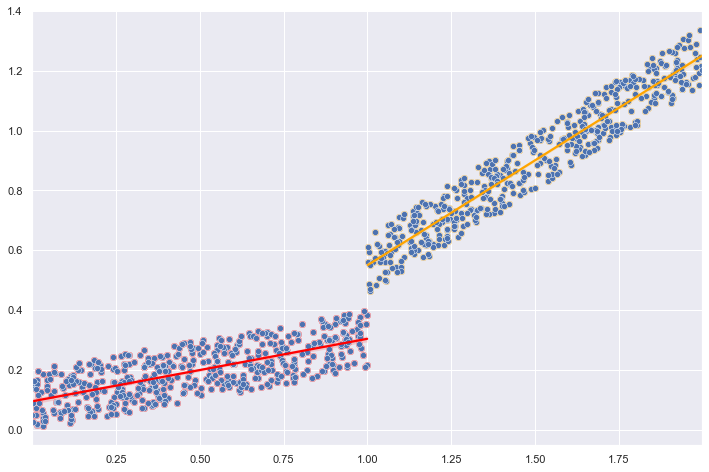

In [7]:
sns.regplot(x=xleft, y=yleft, color = 'red')
sns.regplot(x=xright, y=yright, color = 'orange')
sns.scatterplot(x=x, y=y);

## Assignment 1 (2 points). Write a function that computes the size of discontinuity in the OLS context with the data above.

In [8]:
def rd1(x, y, loc = 0):
    data = np.vstack((x,y))
    df = pd.DataFrame(data.T, columns = ['x', 'y'])

    df_left = df[df.x<loc] #left dataset
    df_right = df[df.x>=loc] #right dataset
    
    #OLS model and its value in loc point for left dataset
    model_left = smfOLS('y~x', df_left)
    results_left = model_left.fit()
    beta_left = results_left.params
    value_left = beta_left[0] + beta_left[1]*loc
    
    #OLS model and its value in loc point for right dataset
    model_right = smfOLS('y~x', df_right)
    results_right = model_right.fit()
    beta_right = results_right.params
    value_right = beta_right[0] + beta_right[1]*loc
    
    return np.abs(value_right - value_left) #return their difference

In [9]:
rd1(x, y, loc = 1)

0.24585006662298503

The true size of discontinuity is **0.25**, which we set during build x and y data in function **func1**, so this function works pretty good.

## Data for assignments 2 and 3

In [10]:
def func2(x):
    if x < 1:
        return np.sin(6*x)+3
    if x >= 1:
        return np.cos(6*x)+4

x = np.random.uniform(0,2, 1000)
y = np.array([func2(i) for i in x]) + np.random.uniform(0,1,1000)

In [11]:
print('True size of discontinuity: {}'.format(np.cos(6) -np.sin(6)+1))

True size of discontinuity: 2.239585784849292


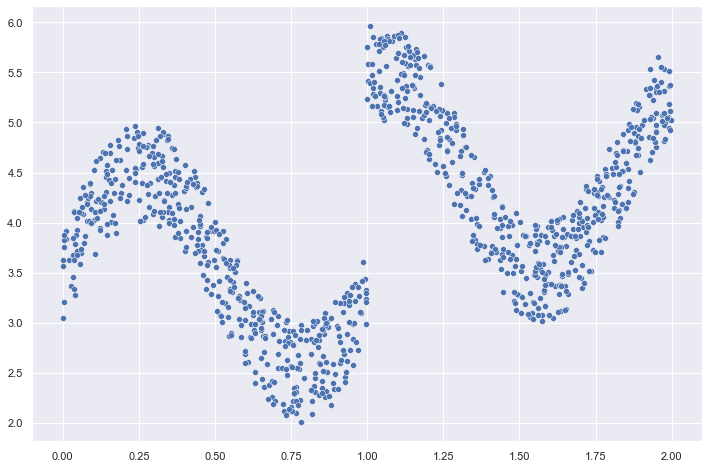

In [12]:
sns.scatterplot(x=x, y=y);

**Reflection method: mirror the data to the other side of the threshold, and use it to get the value at the boundary properly. Otherwise the estimate will fall towards zero**

## Assignment 2 (3 points).Write a function that computes the size of discontinuity in the  context of local-CONSTANT regression with the data above, with boundary correction. Plot the fit. You can use any intermediate packages.

In [13]:
def rd2(x, y, loc = 0):
    data = np.vstack((x,y))
    df = pd.DataFrame(data.T, columns = ['x', 'y'])

    xleft = df[df.x<loc].x.values
    xright = df[df.x>=loc].x.values
    yleft = df[df.x<loc].y.values
    yright = df[df.x>=loc].y.values
    
    #boundary correction and sorted data
    
    #left data
    #mirror not all data, but 1/3, because when mirror all data there is an error about divizion zero
    xleft1 = np.array([xleft, 2*loc-xleft[::-1]]).reshape(-1)
    yleft1 = np.array([yleft, yleft[::-1]]).reshape(-1)
    df_left = pd.DataFrame(np.vstack((xleft1,yleft1)).T, columns = ['x', 'y'])
    df_left = df_left[df_left.x < loc*4/3].sort_values('x', ascending=True).reset_index(drop=True)
    
    #right data
    #mirror not all data, but 1/3, because when mirror all data there is an error about divizion zero
    xright1 = np.array([2*loc-xright[::-1], xright]).reshape(-1) #mirror x
    yright1 = np.array([yright[::-1], yright]).reshape(-1) #mirror y
    df_right = pd.DataFrame(np.vstack((xright1,yright1)).T, columns = ['x', 'y'])
    df_right = df_right[(df_right.x > loc*2/3)].sort_values('x', ascending=True).reset_index(drop=True)
    
    #MODELS
    #local-CONSTANT model and its value in loc point for right dataset
    model_left = KernelReg(df_left.y, df_left.x, var_type = 'c', reg_type='lc')
    fit_left = model_left.fit()
    value_left = fit_left[0][len(xleft)-1]

    #local-CONSTANT model and its value in loc point for right dataset
    model_right = KernelReg(df_right.y, df_right.x, var_type = 'c', reg_type='lc')
    fit_right = model_right.fit()
    value_right = fit_right[0][-len(xright)]
    
    return np.abs(value_right - value_left), fit_left[0][:len(xleft)], fit_right[0][-len(xright):]

In [14]:
size_discontinuity, left, right = rd2(x, y, loc = 1)

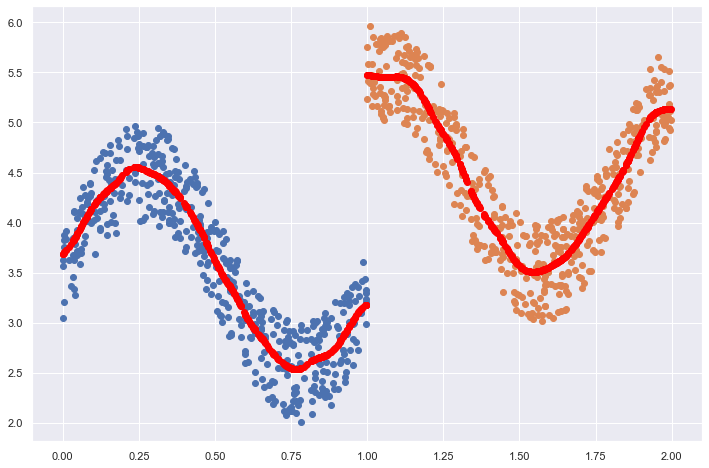

In [15]:
loc=1
data = np.vstack((x,y))
df = pd.DataFrame(data.T, columns = ['x', 'y'])
df = df.sort_values('x', ascending=True).reset_index(drop=True)

xleft = df[df.x<loc].x.values
xright = df[df.x>=loc].x.values

yleft = df[df.x<loc].y.values
yright = df[df.x>=loc].y.values

plt.scatter(xleft, yleft)
plt.scatter(xleft, left, color = 'red')
plt.scatter(xright, yright)
plt.scatter(xright, right, color = 'red');

In [16]:
size_discontinuity

2.2982314439224187

As you can see the size of discontinuity in the context of local-CONSTANT regression is almost equal to true size **2.23**, which demostrates power of this method to estimate the size of discontinuity.

## Assignment 3 (5 points).Write a function that computes the size of discontinuity in the  context of local-LINEAR regression with the data above, with boundary correction. Plot the fit. You have to do everything BY HAND.

In [17]:
def loss(Y, X, w, beta): #weighted loss 
    z = Y - X@beta
    return w*z@z.T

def kernel(d, frac):
    abs_d = np.abs(d)
    cut_point = np.sort(abs_d)[round(frac * len(d))] 
    
    #sorted distance to points and find the most available remote point -
    #when the number of points is equal to frac*len(df)
    
    return abs_d * (abs_d < cut_point).astype(int) #use mask and return 0 or abs(d), where abs(d)<cut_point
     
#other kernel could be
#band = 0.25 
#return np.maximum(band-np.abs(d),0)/(band*band)
#but let's use just abs of distance
    
def find_predictions(dataframe, frac):
    prediction = []
    for i in range(len(dataframe)):
        observation = dataframe[dataframe.index==i]
        
        df1 = dataframe
        w = kernel(np.array(dataframe.x) - float(observation.x), frac) #weights
        
        Y = dataframe.y.values
        X = dataframe.x.values
        X = sma.add_constant(X)

        covs = X.shape[1]
        bounds = [(None, None)]*covs
        results = spopt.shgo(lambda b: loss(Y, X, w, b), bounds).x
        
        pred = results[0] + results[1]*float(observation.x)
        prediction.append(pred)
        
    return np.array(prediction)

In [18]:
def rd3(x, y, loc = 0, frac = 0.5):
    data = np.vstack((x,y))
    df = pd.DataFrame(data.T, columns = ['x', 'y'])

    xleft = df[df.x<loc].x.values
    xright = df[df.x>=loc].x.values
    yleft = df[df.x<loc].y.values
    yright = df[df.x>=loc].y.values
    
    #boundary correction and sorted data
    
        #left data
        #mirror all data
    xleft1 = np.array([xleft, 2*loc-xleft[::-1]]).reshape(-1) #mirror x
    yleft1 = np.array([yleft, yleft[::-1]]).reshape(-1) #mirror y
    df_left = pd.DataFrame(np.vstack((xleft1,yleft1)).T, columns = ['x', 'y'])
    df_left = df_left.sort_values('x', ascending=True).reset_index(drop=True) #sorted
    
        #right data
        #mirror all data
    xright1 = np.array([2*loc-xright[::-1], xright]).reshape(-1) #mirror x
    yright1 = np.array([yright[::-1], yright]).reshape(-1) #mirror y
    df_right = pd.DataFrame(np.vstack((xright1,yright1)).T, columns = ['x', 'y'])
    df_right = df_right.sort_values('x', ascending=True).reset_index(drop=True) #sorted
    
    #find predictions in each point
        #left
    fit_left = find_predictions(df_left, frac)
    value_left = fit_left[len(xleft)-1]
        #right
    fit_right = find_predictions(df_right, frac)
    value_right = fit_right[-len(xright)]
    
    return np.abs(value_right - value_left), fit_left[:len(xleft)], fit_right[-len(xright):]

In [19]:
size_discontinuity, left, right = rd3(x, y, loc = 1, frac = 0.1)

I use $frac = 0.1$, because close points are the most significant to estimate right weights and get careful predictions. As you can see from the graph below x is limited in small length and changeable, so it is reasonable to use small frac to get need info (distance betweeen points) only from useful points - close points, which provide building correct weighted matrix. Therefore, I assume that frac no more than 0.1 is well for that purpose.

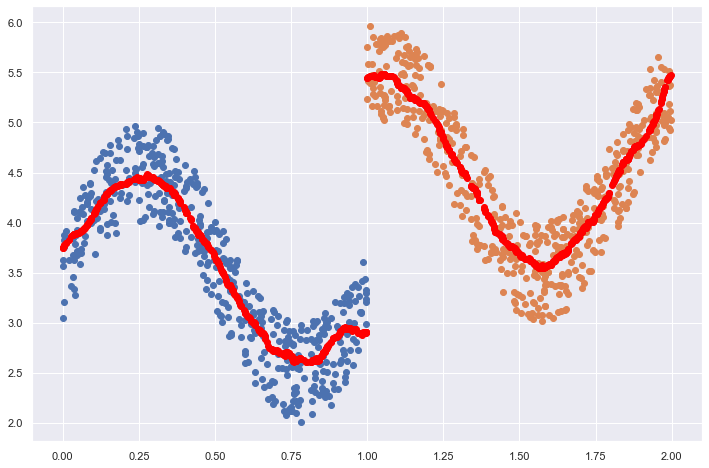

In [20]:
data = np.vstack((x,y))
df = pd.DataFrame(data.T, columns = ['x', 'y'])
df = df.sort_values('x', ascending=True).reset_index(drop=True)

xleft = df[df.x<loc].x.values
xright = df[df.x>=loc].x.values

yleft = df[df.x<loc].y.values
yright = df[df.x>=loc].y.values

plt.scatter(xleft, yleft)
plt.scatter(xleft, left, color = 'red')
plt.scatter(xright, yright)
plt.scatter(xright, right, color = 'red');

In [21]:
size_discontinuity

2.539501146139338

As you can see the size of discontinuity in the context of local-Linear regression is worse estimated for this data than in local-CONSTANT, whereas it is still near true size **2.23** and equal **2.5**